In [1]:
import os
import shutil
import tempfile
import json
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
import pandas as pd
import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
   
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    RandSpatialCropSamplesd,
    RandCropByLabelClassesd,
    CenterSpatialCropd,
    SpatialPadd,
    RandAffined,OneOf,RandGridDistortiond,RandCoarseDropoutd,RandScaleIntensityd,Lambdad
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR,UNet,UNETR,VNet,DynUNet
from torch.optim import lr_scheduler

from monai.data import (
    ThreadDataLoader,
    PersistentDataset,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    SmartCacheDataset,
)

import torch

print_config()

MONAI version: 1.3.2
Numpy version: 1.23.5
Pytorch version: 2.4.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: c:\Users\<username>\Documents\monai_ssbr\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.9.3
Pillow version: 9.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.1+cu118
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSIO

In [2]:
path_ped = "C:\\Users\\Michael\\Documents\\monai_ssbr\\split_img\\" 
path_total ="C:\\Users\\Michael\\Documents\\monai_ssbr\\Totalsegmentator_dataset_small_v201\\"

In [3]:

removed = {'Pediatric-CT-SEG-0296A78B',
 'Pediatric-CT-SEG-03A54FD1',
 'Pediatric-CT-SEG-04D3978C',
 'Pediatric-CT-SEG-086CF08B',
 'Pediatric-CT-SEG-0B387FB5',
 'Pediatric-CT-SEG-0C49C1B7',
 'Pediatric-CT-SEG-0C5320A6',
 'Pediatric-CT-SEG-0C78EBBE',
 'Pediatric-CT-SEG-0D4D6667',
 'Pediatric-CT-SEG-0D7F3188',
 'Pediatric-CT-SEG-0E3FF02E',
 'Pediatric-CT-SEG-1069C71E',
 'Pediatric-CT-SEG-11D16CF0',
 'Pediatric-CT-SEG-1360E26F',
 'Pediatric-CT-SEG-1D20EAD2',
 'Pediatric-CT-SEG-1F5E00BB',
 'Pediatric-CT-SEG-218C084A',
 'Pediatric-CT-SEG-23DB510F',
 'Pediatric-CT-SEG-2744A45D',
 'Pediatric-CT-SEG-27BFD847',
 'Pediatric-CT-SEG-2D905107',
 'Pediatric-CT-SEG-305BA50D',
 'Pediatric-CT-SEG-32C20E78',
 'Pediatric-CT-SEG-340BB9AF',
 'Pediatric-CT-SEG-34ECBB32',
 'Pediatric-CT-SEG-355',
 'Pediatric-CT-SEG-356',
 'Pediatric-CT-SEG-361304ED',
 'Pediatric-CT-SEG-37105B7A',
 'Pediatric-CT-SEG-374',
 'Pediatric-CT-SEG-380',
 'Pediatric-CT-SEG-390',
 'Pediatric-CT-SEG-392',
 'Pediatric-CT-SEG-393',
 'Pediatric-CT-SEG-399',
 'Pediatric-CT-SEG-39A80196',
 'Pediatric-CT-SEG-3B5CED31',
 'Pediatric-CT-SEG-3EE98BA3',
 'Pediatric-CT-SEG-402',
 'Pediatric-CT-SEG-40210ED4',
 'Pediatric-CT-SEG-404',
 'Pediatric-CT-SEG-420FD7F5',
 'Pediatric-CT-SEG-42BCEEFD',
 'Pediatric-CT-SEG-43920D5B',
 'Pediatric-CT-SEG-474F00E2',
 'Pediatric-CT-SEG-4934405E',
 'Pediatric-CT-SEG-4A25C4F3',
 'Pediatric-CT-SEG-4A8A81FB',
 'Pediatric-CT-SEG-4C1A38AE',
 'Pediatric-CT-SEG-51733317',
 'Pediatric-CT-SEG-51BBDB38',
 'Pediatric-CT-SEG-52AA7DB5',
 'Pediatric-CT-SEG-5B1E0A68',
 'Pediatric-CT-SEG-5F74CD3E',
 'Pediatric-CT-SEG-66065C99',
 'Pediatric-CT-SEG-6D6D4CD1',
 'Pediatric-CT-SEG-792705D7',
 'Pediatric-CT-SEG-7A676F9C',
 'Pediatric-CT-SEG-7CE37159',
 'Pediatric-CT-SEG-8110AFDA',
 'Pediatric-CT-SEG-84CF10F5',
 'Pediatric-CT-SEG-8538895B',
 'Pediatric-CT-SEG-858CCBEC',
 'Pediatric-CT-SEG-885A32DF',
 'Pediatric-CT-SEG-8877A5A3',
 'Pediatric-CT-SEG-8BB6DC24',
 'Pediatric-CT-SEG-8D386469',
 'Pediatric-CT-SEG-93718342',
 'Pediatric-CT-SEG-9B29D191',
 'Pediatric-CT-SEG-9D15A505',
 'Pediatric-CT-SEG-9EC8B17D',
 'Pediatric-CT-SEG-A00B1583',
 'Pediatric-CT-SEG-A1FF5A26',
 'Pediatric-CT-SEG-A52B1351',
 'Pediatric-CT-SEG-A768A490',
 'Pediatric-CT-SEG-A783807D',
 'Pediatric-CT-SEG-A79D004C',
 'Pediatric-CT-SEG-A975CECD',
 'Pediatric-CT-SEG-AC36D24F',
 'Pediatric-CT-SEG-ACCA52D8',
 'Pediatric-CT-SEG-AF83DAF1',
 'Pediatric-CT-SEG-B01E38C9',
 'Pediatric-CT-SEG-B0308EC6',
 'Pediatric-CT-SEG-B05647FA',
 'Pediatric-CT-SEG-B1B6F67A',
 'Pediatric-CT-SEG-B1CBA303',
 'Pediatric-CT-SEG-B42CD321',
 'Pediatric-CT-SEG-BB8C3187',
 'Pediatric-CT-SEG-C7338499',
 'Pediatric-CT-SEG-C9494BA3',
 'Pediatric-CT-SEG-CA967BD7',
 'Pediatric-CT-SEG-CF28F28B',
 'Pediatric-CT-SEG-D1572D48',
 'Pediatric-CT-SEG-D20DA719',
 'Pediatric-CT-SEG-D6EED145',
 'Pediatric-CT-SEG-DD7F4855',
 'Pediatric-CT-SEG-E1FF3C7E',
 'Pediatric-CT-SEG-E7702A63',
 'Pediatric-CT-SEG-ED076087',
 'Pediatric-CT-SEG-F320D54C',
 'Pediatric-CT-SEG-F4E60C6E',
 'Pediatric-CT-SEG-F50AD62F',
 'Pediatric-CT-SEG-FAC9474D',
 'Pediatric-CT-SEG-FC6A7B5A'}

removed.add('Pediatric-CT-SEG-CF28F28B')
len(removed)

104

In [4]:
seg_model = '1'
sections = {
        "1": [
            'Femoral Head Rig',
            'Femoral Head Lef',
            "Bladder",
            "Rectum"
        ],
        "0": [
            "Liver",
            "Stomach",
            "Spleen",
            "Pancreas",
            "Adrenal Right",
            "Adrenal Left",
            "Gall Bladder",
            'Kidney Right',
            'Kidney Left',
        ],
        "2": [
            'Lung_R',
            'Lung_L',
            "Heart",
            "Esophagus"
        ],
        "3": [
            "Small Intestine",
            "Large Intestine",
            "Duodenum",
            #"Rectum"
        ],
        "4": [
            'Adrenal Right',
            'Adrenal Left',
        ],
        "5": [
            "Pancreas"
        ],
    "7": [
            "Femoral Head Rig",
            "Femoral Head Lef",
            "Bladder",
            "Rectum",
        #'UteroCervix','Prostate'
        ],
        "whole_body" :[
            'Femoral Head Rig',
            'Femoral Head Lef',
            'Rectum',
            'Bladder',
            'Large Intestine',
            'Small Intestine',
            'Duodenum',
            'Kidney Right',
            'Kidney Left',
            'Adrenal Right',
            'Adrenal Left',
            'Stomach',
            'Spleen',
            'Pancreas',
            'Liver',
            'Gall Bladder',
            'Lung_R',
            'Lung_L',
            'Heart',
            'Esophagus',
        ]
    
    }

oragns={
 'Bones': 1,
 'Lung_R': 2,
 'Stomach': 3,
 'Spleen': 4,
 'Spinal Canal': 5,
 'Small Intestine': 6,
 'Rectum': 7,
 'Prostate': 8,
 'Pancreas': 9,
 'Liver': 10,
 'Large Intestine': 11,
 'Kidney Right': 12,
 'Kidney Left': 13,
 'Heart': 14,
 'Gonads': 15,
 'Gall Bladder': 16,
 'Femoral Head Rig': 17,
 'Femoral Head Lef': 18,
 'Esophagus': 19,
 'Duodenum': 20,
 'Bladder': 21,
 'Adrenal Right': 22,
 'Adrenal Left': 23,
 'Lung_L': 24,
 'Thymus': 25,
 'UteroCervix': 26,
 'Breast Right': 27,
 'Breast Left': 28,
}


nameLbIndMap ={}
counter =1
for label in sections[seg_model]:
    nameLbIndMap[label] = counter
    counter +=1

inv_label = {v: k for k, v in nameLbIndMap.items()}
nameLbIndMap

{'Femoral Head Rig': 1, 'Femoral Head Lef': 2, 'Bladder': 3, 'Rectum': 4}

In [5]:
IMG_FOLDER_TRAIN ='C:\\Users\\Michael\\Documents\\monai_ssbr\\split_img\\train\\'
IMG_FOLDER_VAL ='C:\\Users\\Michael\\Documents\\monai_ssbr\\split_img\\val\\'
IMG_FOLDER_TEST ='C:\\Users\\Michael\\Documents\\monai_ssbr\\split_img\\test\\'
LABEL_FOLDER = "C:\\Users\\Michael\\Documents\\monai_ssbr\\segmentation_label_28\\"
def create_dataset(path):
    dataset = []
    for element in os.listdir(path):
        if element.split("_")[0] not in removed:
            dataset.append({
                "image":os.path.join(path,element),
                "label":os.path.join(LABEL_FOLDER,element.replace("_img", "_RTseg")),
            })
    return dataset
train = create_dataset(IMG_FOLDER_TRAIN)
val = create_dataset(IMG_FOLDER_VAL)
test = create_dataset(IMG_FOLDER_TEST)

In [6]:
bad_labels = list(removed)
landmark_df = pd.read_excel("C:\\Users\\Michael\\Documents\\monai_ssbr\\landmark.xlsx")
landmark_df=landmark_df.drop_duplicates(subset=['filename'])
landmark_df = landmark_df.loc[:, ~landmark_df.columns.str.contains('^Unnamed')]
def gen_summary(model_name):
    post_score_df = pd.DataFrame( columns=["filename",
                              "femoral_start","femoral_end",
                              "bladder_start","bladder_end",
                              "liver_start","liver_end",
                              "lung_start","lung_end",
                              "heart_start","heart_end",
                              "stomach_start","stomach_end",
                              "esophagus_start","esophagus_end",
                              "spleen_start","spleen_end",
                              "pancreas_start","pancreas_end",
                              "duodenum_start","duodenum_end",
                              'small_intestine_start','small_intestine_end',
                              'large_intestine_start','large_intestine_end',
                              'rectum_start','rectum_end',
                              'adrenal_start','adrenal_end',
                              'gall_bladder_start','gall_bladder_end',
                              'kidney_start','kidney_end'])
    path =  "C:\\Users\\Michael\\Documents\\monai_ssbr\\SSBR_experiments\\json\\efficientnet\\train\\"
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            name = filename.split(".")[0]
            f = open(dirpath+filename)
            data = json.load(f)
            scores=data["post_scores"]
            row= landmark_df[landmark_df['filename']==name]
            nifti = nib.load("H:\\monai_ssbr\\split_img\\train\\" + name +".nii.gz")
            z_len = nifti.shape[2]
            score_row = {}
            for c in post_score_df.columns[1:]:
                if row[c].item()!=-1 and name not in bad_labels:
                    #score_row[c]=scores[int(row[c].item())]
                    resampled = int(np.interp(row[c].item(),[0,z_len],[0,len(scores)]))
                    score_row[c]=scores[resampled]
            score_row['filename'] = name  
            post_score_df =pd.concat([post_score_df, pd.DataFrame.from_records([score_row])])
            #post_score_df = post_score_df.append(score_row,ignore_index=True)
        summary = post_score_df.describe()
        return summary
model_summary = gen_summary('efficientnet')
model_summary

,femoral_start,femoral_end,bladder_start,bladder_end,liver_start,liver_end,lung_start,lung_end,heart_start,heart_end,...,large_intestine_start,large_intestine_end,rectum_start,rectum_end,adrenal_start,adrenal_end,gall_bladder_start,gall_bladder_end,kidney_start,kidney_end
count,279.000000,279.000000,277.000000,277.000000,286.000000,286.000000,284.000000,284.000000,285.000000,285.000000,...,279.000000,279.000000,278.000000,278.000000,274.000000,274.000000,268.000000,268.000000,284.000000,284.000000
mean,4.393133,31.302442,15.608300,39.608442,57.563854,77.503028,68.339457,95.953102,72.324058,85.892814,...,32.659809,67.873760,10.282708,41.025848,65.061238,68.627891,60.085278,65.291789,56.916591,67.848903
std,8.632800,6.233473,5.127909,8.338340,2.797279,3.063443,1.947947,13.237783,2.482006,5.987352,...,7.303035,4.508705,6.170184,5.012685,1.925581,1.998131,4.347949,1.649039,2.723432,2.215380
min,-19.551093,22.606498,3.622921,18.816509,48.683762,63.023294,60.299900,70.779157,65.250437,70.779157,...,14.432260,45.263346,-5.021620,20.768879,57.728374,62.610504,1.559884,60.862197,44.631607,60.823600
25%,0.430462,28.482986,12.491629,33.156237,55.983539,75.729109,67.330216,80.847470,70.840648,80.456667,...,28.005630,65.472286,6.060336,37.872689,64.035966,67.224550,58.750316,64.290453,55.393318,66.236742
50%,3.773199,30.801719,15.156578,39.962877,57.686697,77.095352,68.629244,102.651391,72.111393,86.582189,...,31.968228,67.448871,9.706710,40.959872,65.263896,68.503310,60.567258,65.370031,56.991342,67.820052
75%,7.425901,33.058022,18.554481,45.402533,59.498903,78.950398,69.658655,107.470883,73.723153,90.365754,...,37.524339,69.903782,14.072722,43.955987,66.390188,70.134184,61.938476,66.259024,58.775270,69.456329
max,105.328268,106.576024,45.215435,59.982525,65.318351,89.303493,72.612730,112.828266,79.591670,100.180051,...,64.564981,106.540852,45.215435,58.426173,69.747929,73.909159,67.577383,73.463243,65.318351,73.909159


In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return idx

In [8]:
from monai.transforms.transform import MapTransform, RandomizableTransform
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union
from monai.config import DtypeLike, KeysCollection, SequenceStr
class Ssbr_crop(MapTransform):

    def __init__(
        self,
        keys: KeysCollection,
        std_range:float,

        bounding_organ:str,
        min_z_size:int = None,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
      
        self.std_range = std_range
        self.min_z_size = min_z_size
        self.bounding_organ = bounding_organ
        MapTransform.__init__(self, keys, allow_missing_keys)

    def __call__(self, data: Mapping[Hashable, torch.Tensor]) -> Dict[Hashable, torch.Tensor]:
        d = dict(data)
        dirpath = "C:\\Users\\Michael\\Documents\\monai_ssbr\\SSBR_experiments\\json\\efficientnet\\"
        #print(d.keys())
        file = d['image_meta_dict']['filename_or_obj'].split("\\")[-1].split('.')[0]+'.json'
        #pixdim = d['image_meta_dict']['pixdim'][3]
    
        f = open(dirpath+file)
        ssbr_data = json.load(f)
        
        scores = ssbr_data['post_scores']
        organ_set =set()
        for organ in sections[self.bounding_organ]:
            if "Adrenal" in organ:
                organ = 'adrenal'
            if "Kidney" in organ:
                organ = 'kidney'
            if "Femoral" in organ:
                organ = 'Femoral'    
            if "Lung" in organ:
                organ = 'Lung'     
            organ = organ.lower()
            organ ='_'.join(organ.split(' '))
            
            if organ+"_end" not in model_summary.columns:
                continue
            if organ+"_start" not in model_summary.columns:
                continue
            organ_set.add((model_summary[organ+"_start"]["mean"],organ+"_start"))
            organ_set.add((model_summary[organ+"_end"]["mean"],organ+"_end"))
        organ_set = sorted(organ_set, key=lambda tup: tup[0])
        start = organ_set[0][1]
        end = organ_set[-1][1]
        
        start_mean = model_summary[start]["mean"]
        if (start_mean-(self.std_range*model_summary[start]["std"])) <0: 
            start_slice =0
        else: 
            start_slice =find_nearest(scores,start_mean-self.std_range*model_summary[start]["std"])
       
        end_mean = model_summary[end]["mean"]
        end_slice =find_nearest(scores,end_mean+self.std_range*model_summary[end]["std"])
        if self.min_z_size:
            while (end_slice-start_slice)<self.min_z_size:
               
                if start_slice >0:
                    start_slice-=1
                if end_slice<d['image'].shape[3]:
                    end_slice +=1
        #print(start_slice,end_slice)
        d['image'] = d['image'][:,:,:,start_slice:end_slice]
        d['label'] = d['label'][:,:,:,start_slice:end_slice]
        d['image_meta_dict']['crop_slices'] = (start_slice,end_slice)
        #print(d['image_meta_dict']['filename_or_obj'].split("\\")[-1].split('.')[0]+'.json')
        return d

class Relabel(MapTransform):

    def __init__(
        self,
        keys: KeysCollection,
        sections:list,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.sections=sections
        MapTransform.__init__(self, keys, allow_missing_keys)

    def __call__(self, data: Mapping[Hashable, torch.Tensor]) -> Dict[Hashable, torch.Tensor]:
        d = dict(data)
        newlabel =-1
        for organ in self.sections:
            #print(nameLbIndMap[organ])
            d['label'][d['label']==oragns[organ]] = newlabel
            newlabel -=1
        d['label'][d['label']>0] = 0
        d['label'] =  d['label'] *-1
        #print(d['image_meta_dict']['filename_or_obj'].split("\\")[-1].split('.')[0]+'.json')
        return d


In [9]:
num_samples = 1

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = (48, 48, 48)
pix_spacing =(1.5, 1.5, 2.0)
std =1.5
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True,image_only=False),
        Relabel(keys=["label"],sections=sections[seg_model]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        #Lambdad(keys=["image"], func=lambda x: x / x.max()),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=pix_spacing,
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            keys=["image", "label"],
            spatial_size=img_size,
        ),
        #Ssbr_crop(keys=["image", "label",],std_range=std,min_z_size=img_size[2],bounding_organ = seg_model),#,min_z_size=img_size[2]
       
        RandSpatialCropSamplesd(
            keys=["image", "label"],
            num_samples=num_samples,
            roi_size=img_size,
            random_size=False
        ), 
       
        EnsureTyped(keys=("image", "label"), dtype=torch.float32),
     
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True,image_only=False),
        
        Relabel(keys=["label",],sections=sections[seg_model]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        #Lambdad(keys=["image"], func=lambda x: x / x.max()),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=pix_spacing,
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            keys=["image", "label"],
            spatial_size=img_size,
        ),
        EnsureTyped(keys=("image", "label"), dtype=torch.float32),
        #Ssbr_crop(keys=["image", "label",],std_range=1,min_z_size=img_size[2],bounding_organ = seg_model),
        #CenterSpatialCropd(keys=["image", "label",],roi_size =img_size),
    ]
)

c:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [10]:
train_ds = PersistentDataset(
    data=train,
    transform=train_transforms,
    cache_dir="cache",
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)

In [11]:
val_ds = PersistentDataset(
    data=val,
    transform=val_transforms,
    cache_dir="cache_val",
)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1, shuffle=True)


torch.Size([1, 48, 48, 48])


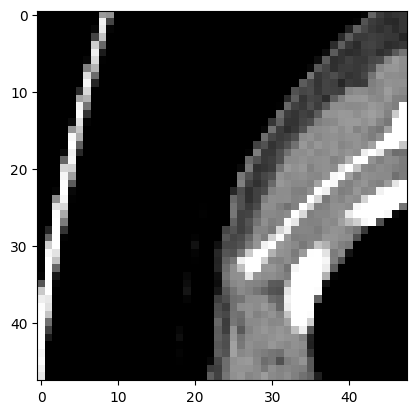

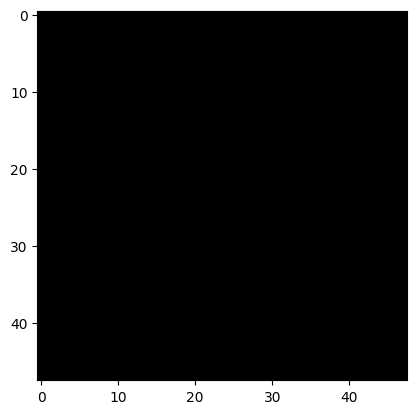

In [12]:
check_data = train_ds[0]
i,l= check_data[0]["image"],check_data[0]["label"]
print(i.shape)
plt.imshow(i[0, :, :, 24].detach().cpu(), cmap="gray")
plt.show()
plt.imshow(l[0, :, :, 24].detach().cpu(), cmap="gray")
plt.show()

In [13]:
def get_kernels_strides(sizes, spacings):
    """
    This function is only used for decathlon datasets with the provided patch sizes.
    When refering this method for other tasks, please ensure that the patch size for each spatial dimension should
    be divisible by the product of all strides in the corresponding dimension.
    In addition, the minimal spatial size should have at least one dimension that has twice the size of
    the product of all strides. For patch sizes that cannot find suitable strides, an error will be raised.
    """
    input_size = sizes
    strides, kernels = [], []
    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        for idx, (i, j) in enumerate(zip(sizes, stride)):
            if i % j != 0:
                raise ValueError(
                    f"Patch size is not supported, please try to modify the size {input_size[idx]} in the spatial dimension {idx}."
                )
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)

    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])
    return kernels, strides
kernels, strides = get_kernels_strides((48, 48, 48),pix_spacing)

In [14]:
nameLbIndMap

{'Femoral Head Rig': 1, 'Femoral Head Lef': 2, 'Bladder': 3, 'Rectum': 4}

In [15]:
out_channels =len(nameLbIndMap)+1
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=out_channels,
    kernel_size=kernels,
    strides=strides,
    upsample_kernel_size=strides[1:],
).to(device)


torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

scaler = torch.cuda.amp.GradScaler()

C:\Users\Michael\AppData\Local\Temp\ipykernel_44276\177273853.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [16]:
max_epochs = 500
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=out_channels)])
post_label = Compose([AsDiscrete(to_onehot=out_channels)])
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
model_name = "RNSA\\final\\section_"+seg_model+"_whole.pth"


In [17]:
post_label = AsDiscrete(to_onehot=out_channels)
post_pred = AsDiscrete(argmax=True, to_onehot=out_channels)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
def validation(epoch_iterator_val,is_cpu = False):
    model.eval()
    dice_metric.reset()
    with torch.no_grad():
            for val_data in epoch_iterator_val:
                if is_cpu:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"],
                    )
                else:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                sw_batch_size = 1
                if is_cpu:
                    val_outputs = sliding_window_inference(
                        val_inputs, img_size, sw_batch_size, model,device=torch.device('cpu'))
                else:
                    val_outputs = sliding_window_inference(
                        val_inputs, img_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
            organ_dice=dice_metric.get_buffer().cpu().numpy()
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
    return metric,organ_dice

def eval_ssbr_crop(file,bounding_organ,std_range,min_z_size):
    dirpath = "C:\\Users\\Michael\\Documents\\monai_ssbr\\SSBR_experiments\\json\\efficientnet\\"
    file = file.split("\\")[-1].split('.')[0]+'.json'        
    f = open(dirpath+file)
    ssbr_data = json.load(f)
    scores = ssbr_data['post_scores']
    organ_set =set()
    for organ in sections[bounding_organ]:
        if "Adrenal" in organ:
                organ = 'adrenal'
        if "Kidney" in organ:
                organ = 'kidney'
        if "Femoral" in organ:
                organ = 'Femoral'
        if "Lung" in organ:
                organ = 'Lung' 
        organ = organ.lower()
        organ ='_'.join(organ.split(' '))
        organ_set.add((model_summary[organ+"_start"]["mean"],organ+"_start"))
        organ_set.add((model_summary[organ+"_end"]["mean"],organ+"_end"))
    organ_set = sorted(organ_set, key=lambda tup: tup[0])
    start = organ_set[0][1]
    end = organ_set[-1][1]
    start_mean = model_summary[start]["mean"]
    if (start_mean-(std_range*model_summary[start]["std"])) <0: 
        start_slice =0
    else: 
        start_slice =find_nearest(scores,start_mean-std_range*model_summary[start]["std"])
    end_mean = model_summary[end]["mean"]
    end_slice =find_nearest(scores,end_mean+std_range*model_summary[end]["std"])
    while (end_slice-start_slice)<=min_z_size:
        #print(start_slice,end_slice,min_z_size)
        if start_slice >0:
            start_slice-=1
        if end_slice<=len(scores) or end_slice<=min_z_size:
            end_slice +=1
    return start_slice,end_slice

def validation_crop(epoch_iterator_val):
    model.eval()
    dice_metric.reset()
    with torch.no_grad():
        for data in epoch_iterator_val:
            start_slice,end_slice =eval_ssbr_crop(
                data["image_meta_dict"]['filename_or_obj'][0],
                seg_model,
                std,
                img_size[2],
            ) 
            #print(val_data["image"].shape,val_data["label"].shape,start_slice,end_slice)
            crop_inputs, crop_labels = (
                data["image"][:,:,:,:,start_slice:end_slice].to(device),
                data["label"][:,:,:,:,start_slice:end_slice].to(device),
            )
         
            sw_batch_size = 1
            crop_outputs = sliding_window_inference(
                crop_inputs, img_size, sw_batch_size, model)
            post_outputs = [post_pred(i) for i in decollate_batch(crop_outputs)]
            post_labels = [post_label(i) for i in decollate_batch(crop_labels)]
            #print(val_outputs[0].shape)
            label =[post_label(i) for i in decollate_batch(data["label"])]
            pred = torch.zeros(*label[0].shape)
            pred[0,:,:,:] = 1
            #print(pred[:,:,:,start_slice:end_slice].shape,val_outputs[0].shape)
            pred[:,:,:,start_slice:end_slice] = post_outputs[0]
            
            # compute metric for current iteration
            dice_metric(y_pred=[pred], y=label)
            #print(dice_metric.get_buffer().cpu().numpy())

        metric = dice_metric.aggregate().item()
        organ_dice=dice_metric.get_buffer().cpu().numpy()
        
    return metric,organ_dice

In [18]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        x, y  = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        #print(x.shape,y.shape)
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        #print(
        #    f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #    f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        metric,organ_dice= validation(val_loader)
        #metric,organ_dice = validation_crop(val_loader)
        metric_values.append(metric)
        print(organ_dice)
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(
                 model_name))
            print("saved new best metric model")
            #print(dice_metric.get_buffer().cpu().numpy())
        print(
            f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            f"\nbest mean dice: {best_metric:.4f} "
            f"at epoch: {best_metric_epoch}"
        )

----------
epoch 1/500


C:\Users\Michael\AppData\Local\Temp\ipykernel_44276\1670291779.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\Michael\Documents\monai_ssbr\venv\lib\site-packages\monai\data\dataset.py:386: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

epoch 1 average loss: 4.1855
----------
epoch 2/500
epoch 2 average loss: 3.0167
[[9.95692790e-01 1.54738883e-02 1.43454876e-02 0.00000000e+00
  0.00000000e+00]
 [9.95259583e-01 2.80382019e-02 1.71441454e-02 0.00000000e+00
  5.19345631e-04]
 [9.97745872e-01 1.08339190e-02 5.13440045e-03 0.00000000e+00
  0.00000000e+00]
 [9.93667066e-01 9.26315784e-03 1.75456293e-02 0.00000000e+00
  5.78034669e-04]
 [9.91963327e-01 2.65747327e-02 2.26570554e-02 0.00000000e+00
  1.81752097e-04]
 [9.91075456e-01 1.26488367e-02 6.44718390e-03 1.66733353e-05
  0.00000000e+00]
 [9.93002415e-01 9.31156054e-03 9.18407366e-03 0.00000000e+00
  0.00000000e+00]
 [9.93977070e-01 7.00142905e-02 2.29680017e-02 0.00000000e+00
  6.59340643e-04]
 [9.96745288e-01 4.44342978e-02 1.92797389e-02 0.00000000e+00
  0.00000000e+00]
 [9.94352221e-01 3.36797796e-02 1.11649772e-02 0.00000000e+00
  0.00000000e+00]
 [9.96323526e-01 1.74711030e-02 1.63171273e-02 0.00000000e+00
  0.00000000e+00]
 [9.93200898e-01 1.76360719e-02 1.27936

In [19]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        
        Relabel(keys=["label",],sections=sections[seg_model]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
   
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            keys=["image", "label"],
            spatial_size=img_size,
        ),
        EnsureTyped(keys=("image", "label"), dtype=torch.float32),
        #Ssbr_crop(keys=["image", "label",],std_range=1.5,min_z_size=img_size[2],bounding_organ = seg_model),
    ]
)



In [22]:
model.load_state_dict(torch.load(model_name))

C:\Users\Michael\AppData\Local\Temp\ipykernel_20616\3513103043.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


<All keys matched successfully>

In [20]:

test_ds = CacheDataset(
    data=test, transform=val_transforms, cache_rate=1.0#num_workers=4
)
test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=1)

Loading dataset: 100%|██████████| 27/27 [03:20<00:00,  7.42s/it]


In [21]:
metric,organ_dice= validation(test_loader)
mean_organ = np.average(organ_dice,axis=0)


In [22]:
for i in range(len(sections[seg_model])):
  print(sections[seg_model][i] +": "+ str(mean_organ[i+1]))
print("Overall Dice: " + str(metric))
dice_metric.get_buffer()

Femoral Head Rig: 0.86803734
Femoral Head Lef: 0.8753276
Bladder: 0.8008988
Rectum: 0.72252196
Overall Dice: 0.8531166315078735


tensor([[0.9992, 0.7707, 0.7880, 0.9438, 0.8665],
        [0.9984, 0.9484, 0.9504, 0.9405, 0.9151],
        [0.9989, 0.9388, 0.9194, 0.9592, 0.8767],
        [0.9990, 0.8504, 0.8294, 0.6274, 0.5889],
        [0.9989, 0.8585, 0.9168, 0.2598, 0.2202],
        [0.9987, 0.9165, 0.9203, 0.9334, 0.8108],
        [0.9992, 0.9429, 0.9603, 0.9077, 0.7154],
        [0.9988, 0.8239, 0.8976, 0.6762, 0.3838],
        [0.9990, 0.8364, 0.8955, 0.9494, 0.7451],
        [0.9978, 0.9671, 0.9578, 0.7809, 0.8192],
        [0.9990, 0.8269, 0.8736, 0.9140, 0.8575],
        [0.9980, 0.7546, 0.5312, 0.3403, 0.6740],
        [0.9988, 0.9065, 0.9307, 0.8849, 0.8743],
        [0.9993, 0.8619, 0.8681, 0.9389, 0.5905],
        [0.9980, 0.9257, 0.9193, 0.4829, 0.5176],
        [0.9987, 0.7478, 0.7203, 0.7646, 0.8108],
        [0.9991, 0.7796, 0.8475, 0.9503, 0.6808],
        [0.9996, 0.9384, 0.8904, 0.9495, 0.8889],
        [0.9975, 0.8972, 0.8871, 0.2469, 0.6789],
        [0.9992, 0.9175, 0.9266, 0.9243, 0.7831],


In [26]:
metric,organ_dice= validation_crop(test_loader)
mean_organ = np.average(organ_dice,axis=0)


In [27]:
for i in range(len(sections[seg_model])):
  print(sections[seg_model][i] +": "+ str(mean_organ[i+1]))
print("Overall Dice: " + str(metric))
dice_metric.get_buffer()

Small Intestine: 0.826044
Large Intestine: 0.807857
Duodenum: 0.63533336
Overall Dice: 0.8164805173873901


tensor([[0.9974, 0.8243, 0.8250, 0.6412],
        [0.9970, 0.8232, 0.8420, 0.6512],
        [0.9953, 0.8248, 0.7345, 0.5490],
        [0.9979, 0.8506, 0.7396, 0.7434],
        [0.9948, 0.7759, 0.5719, 0.6981],
        [0.9956, 0.8568, 0.8008, 0.6637],
        [0.9966, 0.8654, 0.8998, 0.8369],
        [0.9984, 0.8569, 0.8129, 0.6011],
        [0.9969, 0.9044, 0.8679, 0.7016],
        [0.9930, 0.7370, 0.8690, 0.4049],
        [0.9980, 0.8563, 0.8353, 0.7126],
        [0.9969, 0.7220, 0.8887, 0.3377],
        [0.9963, 0.8492, 0.9020, 0.7961],
        [0.9977, 0.8611, 0.8618, 0.4743],
        [0.9934, 0.7986, 0.6689, 0.6105],
        [0.9986, 0.8828, 0.8786, 0.7232],
        [0.9983, 0.8481, 0.8455, 0.6797],
        [0.9956, 0.8411, 0.8076, 0.6601],
        [0.9980, 0.8505, 0.7497, 0.6550],
        [0.9946, 0.8588, 0.8422, 0.6645],
        [0.9934, 0.7799, 0.7680, 0.4310],
        [0.9984, 0.8131, 0.8718, 0.6565],
        [0.9986, 0.9070, 0.7964, 0.7849],
        [0.9982, 0.8463, 0.8997, 0

In [70]:
mean_organ

array([0.9990456 , 0.88744503, 0.8955166 , 0.875987  , 0.7461708 ],
      dtype=float32)

In [2]:
import numpy as np
import scipy.stats as stats
data = [0.9689,
0.9736,
0.969,
0.9746,
0.9723,
0.9723,
0.9759,
0.9733,
0.9664,
0.946,
0.9756,
0.9701,
0.9697,
0.9742,
0.9741,
0.9694,
0.9725,
0.9734,
0.9639,
0.9683,
0.9397,
0.9638,
0.9715,
0.9656,
0.9599,
0.9499,
0.9815,

]

# Calculate the sample mean and standard error
mean = np.mean(data)
sem = stats.sem(data)  # Standard Error of the Mean
confidence_level = 0.95
degrees_freedom = len(data) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=mean, scale=sem)
# Display the results
print(f"Mean: {mean}")
print(f"95% Confidence Interval: {confidence_interval}")

Mean: 0.9679777777777778
95% Confidence Interval: (0.9642476366365796, 0.971707918918976)


In [ ]:
mean_organ

array([0.9990456 , 0.88744503, 0.8955166 , 0.875987  , 0.7461708 ],
      dtype=float32)

In [67]:
path = "C:\\Users\\Michael\\Documents\\monai_ssbr\\split_img\\test\\"
for p in os.listdir(path):
    img = nib.load(os.path.join(path,p))
    header = img.header
    print(header)

    # Scanner type may not be directly listed, but you can try looking for it
    # in auxiliary fields (this depends on the data).
    # For example, some scanner information could be in the description field:
    scanner_info = header.get('descrip', 'No scanner information found')

    print("Scanner type:", scanner_info)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 170   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.390625 0.390625 2.       0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 110.9
qoffset_y       : 100.0
qoffset_z       : -362.6

In [95]:
models = {}
path = "C:\\Users\\Michael\\Documents\\monai_ssbr\\split_img\\test\\"
for p in os.listdir(path):
    s=p.split("_")[0]
    path_s = "C:\\Users\\Michael\\Desktop\\manifest-1647979711903\\Pediatric-CT-SEG\\" +s
    for f in  os.listdir(os.path.join(path_s)):
        for file in  os.listdir(os.path.join(path_s,f)):
            
            if "-CT" in file:
                d = os.listdir(os.path.join(path_s,f,file))[0]
                print(d)
                print(os.path.join(path_s,f,file,d))
                dicom_data = pydicom.dcmread(os.path.join(path_s,f,file,d))
                manufacturer = dicom_data.get('Manufacturer', 'Unknown')
                model = dicom_data.get('ManufacturerModelName', 'Unknown')
                station_name = dicom_data.get('StationName', 'Unknown')
                software_version = dicom_data.get('SoftwareVersions', 'Unknown')
                if model not in models:
                    models[model]= []
                models[model].append(s)
                print(f"Manufacturer: {manufacturer}")
                print(f"Model: {model}")
                print(f"Station Name: {station_name}")
                print(f"Software Version: {software_version}")
         

1-001.dcm
C:\Users\Michael\Desktop\manifest-1647979711903\Pediatric-CT-SEG\Pediatric-CT-SEG-050CB44A\11-02-2005-NA-CT-05478\444.000000-CT-79270\1-001.dcm
Manufacturer: GE MEDICAL SYSTEMS
Model: LightSpeed VCT
Station Name: Unknown
Software Version: gmp_vct.42
1-001.dcm
C:\Users\Michael\Desktop\manifest-1647979711903\Pediatric-CT-SEG\Pediatric-CT-SEG-0C5320A6\10-03-2009-NA-CT-38176\544.000000-CT-44560\1-001.dcm
Manufacturer: SIEMENS
Model: SOMATOM Definition AS+
Station Name: Unknown
Software Version: syngo CT VA48A
1-001.dcm
C:\Users\Michael\Desktop\manifest-1647979711903\Pediatric-CT-SEG\Pediatric-CT-SEG-0C78EBBE\12-28-2004-NA-CT-35910\444.000000-CT-09487\1-001.dcm
Manufacturer: GE MEDICAL SYSTEMS
Model: LightSpeed VCT
Station Name: Unknown
Software Version: gmp_vct.42
1-001.dcm
C:\Users\Michael\Desktop\manifest-1647979711903\Pediatric-CT-SEG\Pediatric-CT-SEG-1188A817\10-27-2009-NA-CT-57260\544.000000-CT-67449\1-001.dcm
Manufacturer: SIEMENS
Model: SOMATOM Definition AS+
Station Name:

In [96]:
models

{'LightSpeed VCT': ['Pediatric-CT-SEG-050CB44A',
  'Pediatric-CT-SEG-0C78EBBE',
  'Pediatric-CT-SEG-11FCDCBD',
  'Pediatric-CT-SEG-1644392C',
  'Pediatric-CT-SEG-1D20EAD2',
  'Pediatric-CT-SEG-3B5CED31',
  'Pediatric-CT-SEG-491B83F3',
  'Pediatric-CT-SEG-4A25C4F3',
  'Pediatric-CT-SEG-4B20AED7',
  'Pediatric-CT-SEG-51733317',
  'Pediatric-CT-SEG-57A2E054',
  'Pediatric-CT-SEG-59397A22',
  'Pediatric-CT-SEG-66EE3D8A',
  'Pediatric-CT-SEG-769F1A5A',
  'Pediatric-CT-SEG-968A78B3',
  'Pediatric-CT-SEG-AB8F282E',
  'Pediatric-CT-SEG-F0386168',
  'Pediatric-CT-SEG-F50AD62F'],
 'SOMATOM Definition AS+': ['Pediatric-CT-SEG-0C5320A6',
  'Pediatric-CT-SEG-1188A817',
  'Pediatric-CT-SEG-20A9D6EC',
  'Pediatric-CT-SEG-354',
  'Pediatric-CT-SEG-380',
  'Pediatric-CT-SEG-381',
  'Pediatric-CT-SEG-3B10B8AB',
  'Pediatric-CT-SEG-400',
  'Pediatric-CT-SEG-5B1E0A68',
  'Pediatric-CT-SEG-677673CD',
  'Pediatric-CT-SEG-691FB79F',
  'Pediatric-CT-SEG-826600AF',
  'Pediatric-CT-SEG-84CF10F5',
  'Pediatric-C

In [ ]:
{'LightSpeed VCT': ['Pediatric-CT-SEG-050CB44A',
  'Pediatric-CT-SEG-0C78EBBE',
  'Pediatric-CT-SEG-11FCDCBD',
  'Pediatric-CT-SEG-1644392C',
  'Pediatric-CT-SEG-1D20EAD2',
  'Pediatric-CT-SEG-3B5CED31',
  'Pediatric-CT-SEG-491B83F3',
  'Pediatric-CT-SEG-4A25C4F3',
  'Pediatric-CT-SEG-4B20AED7',
  'Pediatric-CT-SEG-51733317',
  'Pediatric-CT-SEG-57A2E054',
  'Pediatric-CT-SEG-59397A22',
  'Pediatric-CT-SEG-66EE3D8A',
  'Pediatric-CT-SEG-769F1A5A',
  'Pediatric-CT-SEG-968A78B3',
  'Pediatric-CT-SEG-AB8F282E',
  'Pediatric-CT-SEG-F0386168',
  'Pediatric-CT-SEG-F50AD62F'],
 'SOMATOM Definition AS+': ['Pediatric-CT-SEG-0C5320A6',
  'Pediatric-CT-SEG-1188A817',
  'Pediatric-CT-SEG-20A9D6EC',
  'Pediatric-CT-SEG-354',
  'Pediatric-CT-SEG-380',
  'Pediatric-CT-SEG-381',
  'Pediatric-CT-SEG-3B10B8AB',
  'Pediatric-CT-SEG-400',
  'Pediatric-CT-SEG-5B1E0A68',
  'Pediatric-CT-SEG-677673CD',
  'Pediatric-CT-SEG-691FB79F',
  'Pediatric-CT-SEG-826600AF',
  'Pediatric-CT-SEG-84CF10F5',
  'Pediatric-CT-SEG-906B8910',
  'Pediatric-CT-SEG-920AD27A',
  'Pediatric-CT-SEG-A768A490'],
 'Revolution CT': ['Pediatric-CT-SEG-3DAE6E6F',
  'Pediatric-CT-SEG-627003CD',
  'Pediatric-CT-SEG-7C205617',
  'Pediatric-CT-SEG-7E9377C4',
  'Pediatric-CT-SEG-AF83DAF1']}

In [71]:
import pydicom
path = "C:\\Users\\Michael\\Desktop\\manifest-1647979711903\\Pediatric-CT-SEG\\Pediatric-CT-SEG-00DCF4D6\\10-09-2009-NA-CT-45894\\30144.000000-CT-67414\\1-003.dcm"

dicom_data = pydicom.dcmread(path)

# Extract scanner-related information
manufacturer = dicom_data.get('Manufacturer', 'Unknown')
model = dicom_data.get('ManufacturerModelName', 'Unknown')
station_name = dicom_data.get('StationName', 'Unknown')
software_version = dicom_data.get('SoftwareVersions', 'Unknown')
print(f"Manufacturer: {manufacturer}")
print(f"Model: {model}")
print(f"Station Name: {station_name}")
print(f"Software Version: {software_version}")

Manufacturer: GE MEDICAL SYSTEMS
Model: Revolution CT
Station Name: Unknown
Software Version: revo_ct_21a.33
